In [92]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from sqlalchemy import create_engine, inspect, func

In [93]:
import matplotlib
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt


In [94]:
import pandas as pd
from pandas import DataFrame
import sqlite3
import numpy as np
from sqlalchemy import distinct
from sqlalchemy import func



**Step 3 - Climate Analysis and Exploration**

In [95]:
# Create engine 
from sqlalchemy import event
from sqlalchemy import exc
import os

engine = create_engine("sqlite:///hawaii.sqlite",echo=False )

@event.listens_for(engine, "connect")
def connect(dbapi_connection, connection_record):
    connection_record.info['pid'] = os.getpid()

@event.listens_for(engine, "checkout")
def checkout(dbapi_connection, connection_record, connection_proxy):
    pid = os.getpid()
    if connection_record.info['pid'] != pid:
        connection_record.connection = connection_proxy.connection = None
        raise exc.DisconnectionError(
                "Connection record belongs to pid %s, "
                "attempting to check out in pid %s" %
                (connection_record.info['pid'], pid)
        )


In [96]:
# Declare a Base using `automap_base()`
Base = automap_base()

In [97]:
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [98]:
# Print all of the classes mapped to the Base
Base.classes.keys()


['measurement', 'station']

In [99]:
Measurement = Base.classes.measurement
Station = Base.classes.station
conn = engine.connect()


In [100]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station VARCHAR(255)
date VARCHAR(255)
prcp INTEGER
tobs INTEGER


In [101]:
# Create a session
session = Session(engine)

In [102]:
inspector.get_table_names()

['measurement', 'station']

In [103]:
some_list=conn.execute("select date from measurement").fetchall()
last_date=some_list[-1]
print(last_date)

('2017-08-23',)


In [104]:
import datetime as dt
query_date = dt.date(2011, 4, 8) - dt.timedelta(days=15)

print("Start date: ", dt.date(2011, 4, 8) ," "," Finish Date: " , query_date )


Start date:  2011-04-08    Finish Date:  2011-03-24


**Precipitation Analysis**


In [105]:
results = session.query( Measurement.date, Measurement.prcp).\
     order_by(Measurement.date.desc()).all()
plot_data_df=pd.DataFrame(results)
#prcp_list=plot_df['prcp']
#plot_data_df.pop('date')
plot_df=plot_data_df.groupby(['date'])['prcp'].mean().reset_index().tail(365)
#graph_df_01=graph_df.reset_index()
#plot_org_df=plot_df.rename(columns={'prcpt':'Precipitation'}).tail(365)
plot=plot_df.rename(columns={"prcp":"Precipitation"})

#random_list=np.random.choice(date_list)
#graph_df_01=graph_df.reset_index()
date_list=plot['date']
prcp_list=plot['Precipitation']
random_list=np.random.choice(date_list,8)
random_list_sort=np.sort(random_list)[::-1]
plot.head()


,date,Precipitation
2427,2016-08-24,1.332857
2428,2016-08-25,0.077143
2429,2016-08-26,0.016667
2430,2016-08-27,0.053333
2431,2016-08-28,0.516667


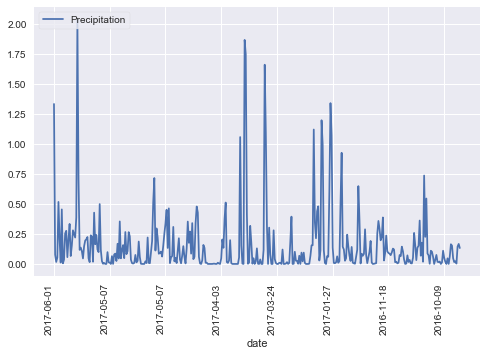

In [106]:
new_df=plot_df.plot(x=date_list,subplots=True)
#ax = fig.add_subplot(111)
#fig, ax = plt.subplots(111)
#ax.set_xticks(date)
xlabels=random_list_sort
plt.xticks(np.arange(0,365,50),xlabels, rotation = 'vertical')
plt.xlabel("date")
plt.legend(labels=['Precipitation'],loc='upper left',frameon=True)
plt.show()

**Station Analysis**


In [107]:
stations=session.query(func.count(distinct(Measurement.station))).one()
print(stations)


(9,)


In [108]:
observations=session.query(Measurement.station,func.count(Measurement.tobs)).\
             group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()

print(observations)



('USC00519281', 2772)


In [109]:
temps=session.query(Measurement.station,Measurement.tobs,func.count(Measurement.tobs)).group_by(Measurement.tobs).\
      filter(Measurement.station == 'USC00519281').all()
print(temps)

[('USC00519281', 54, 1), ('USC00519281', 56, 4), ('USC00519281', 57, 6), ('USC00519281', 58, 6), ('USC00519281', 59, 5), ('USC00519281', 60, 15), ('USC00519281', 61, 19), ('USC00519281', 62, 37), ('USC00519281', 63, 33), ('USC00519281', 64, 41), ('USC00519281', 65, 71), ('USC00519281', 66, 80), ('USC00519281', 67, 111), ('USC00519281', 68, 143), ('USC00519281', 69, 193), ('USC00519281', 70, 227), ('USC00519281', 71, 265), ('USC00519281', 72, 290), ('USC00519281', 73, 278), ('USC00519281', 74, 261), ('USC00519281', 75, 204), ('USC00519281', 76, 148), ('USC00519281', 77, 111), ('USC00519281', 78, 88), ('USC00519281', 79, 54), ('USC00519281', 80, 43), ('USC00519281', 81, 22), ('USC00519281', 82, 11), ('USC00519281', 83, 3), ('USC00519281', 84, 1), ('USC00519281', 85, 1)]


In [132]:
plt_data=pd.DataFrame(temps, columns=['Station','Temperature','Frequence'])
plt_data_01=plt_data[['Temperature','Frequence','Station']]
plt_data_02=plt_data_01.drop(columns=['Station'])
plt_data_04=plt_data_02.set_index('Frequence')
#plt_data_04=plt_data_02.reset_index()
x=plt_data_04
#y=plt_data_04['Frequence']
plt_data_04.head()


,Temperature
Frequence,
1,54
4,56
6,57
6,58
5,59


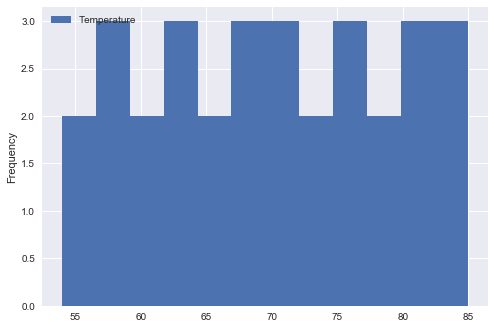

In [111]:
plt.figure()
plt_data_04.plot.hist(x,bins=12)


**Temperature Analysis**

In [147]:

from datetime import date
from datetime import time
import datetime

b=dt.date.today()-dt.timedelta(365)
b

datetime.date(2017, 5, 11)

In [148]:
import datetime as dt
import numpy as np
from datetime import date
from typing import Tuple

def calc_temps (start_date:str,
                end_date:str):
    s_date=datetime.datetime.strptime(start_date,"%Y-%m-%d")
    e_date=datetime.datetime.strptime(end_date,"%Y-%m-%d")
    qu=[Measurement.tobs,
                    func.avg(Measurement.tobs),
                    func.max(Measurement.tobs),
                    func.min(Measurement.tobs)
                     ]
    result=session.query(*qu).\
                filter(Measurement.date > s_date).\
                filter(Measurement.date < e_date).all()
    res_list = list(np.ravel(result))
    return res_list

In [149]:

start_date=('2016-8-30')
end_date=('2016-9-12')
calc_temps(start_date,end_date)

[71.0, 77.77215189873418, 84.0, 71.0]

NameError: name 'res_list' is not defined

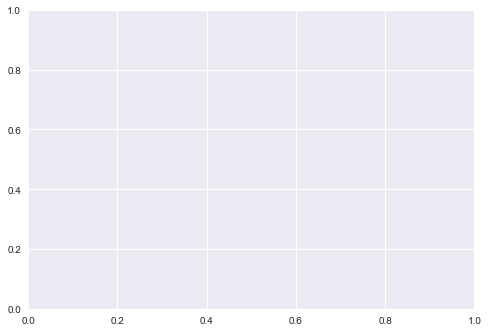

In [151]:
fig, ax = plt.subplots()

x = range(len(res_list))
ax.boxplot(ptps, patch_artist=True)
ax.set_title('IBM PTPs')
fig.tight_layout()
fig.show()
res_list

# **Step 4 - Climate App**

In [ ]:
# 1. Import Flask
from flask import Flask

In [ ]:
app = Flask(__name__)


In [ ]:
@app.route("/api/v1.0/precipitation")
def precipitation():
    year_ago=dt.date.today()-dt.timedelta(365)
    presults = session.query(Measurement.date,Measurement.tobs).\
    filter(Measurement.date > year_ago)all()
    prec_all=[]
    for measurement in presults
    prec_dict={}
    prec_dict['date'].key()=Measurement.date
    prec_dict['tobs'].value()=Measurement.tobs
    prec_all.append(prec_dict)
    
return jsonsfy(prec_all=[]) 

@app.route("/api/v1.0/stations")
def stations():
    sresult=session.query(distinct(Measurement.station).all()
    stations_all=[] 
    for station in sresult
    stations_all.append(station) 
                          
return jsonsfy(stations_all) 
                        
                          
@app.route("/api/v1.0/tobs")
def tobs():
    tresults=session.query(Measurement.tobs).\
             filter(Measurement.date > year_ago)
     tobs_all=[]
    for tob in tresults
    tobs_all.append(tob)
                          
@app.route("/api/v1.0/<start>")
def calc01 ():
    qu=[Measurement.tobs,
                    func.avg(Measurement.tobs),
                    func.max(Measurement.tobs),
                    func.min(Measurement.tobs)
                     ]
    cresult=session.query(*qu).\
                filter(Measurement.date > star_date).al()
print("TVAG,TMAX and TMIN are:",cresult)
                          
@app.route("/api/v1.0/<start>/<end>")

calc_temps(start_date,end_date)                         
print("TVAG,TMAX and TMIN are:",res_list)    
                